In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.dates import WeekdayLocator, DayLocator, HourLocator, DateFormatter, drange, date2num, num2date
from matplotlib.ticker import FormatStrFormatter
from pythermalcomfort.models import utci
from matplotlib.patches import Circle, Ellipse, Rectangle

import os, sys, inspect
HERE_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append(HERE_PATH)
from droplet import droplet

path = "/Users/milan/git/AthleticsChampionshipsHeat/data/"

In [3]:
## LOAD NC DATA
event = "tokyo2020"
utc = 9
tstart = datetime.datetime(2020,7,31,6)     # start day of the event
tend = datetime.datetime(2020,8,9,23)     # end day of the event

ncfile = nc.Dataset(path+event+".nc")
time_hours = ncfile.variables["time"][:]
T = ncfile.variables["t2m"][:,:,:]-273.15       # 2m temperature [°C]
precip_acc = ncfile.variables["tp"][:,:,:]          # Total precipation [mm]
hcc = ncfile.variables["hcc"][:,:,:]            # only central grid point for clouds & rain
mcc = ncfile.variables["mcc"][:,:,:]
lcc = ncfile.variables["lcc"][:,:,:]
ncfile.close()


In [4]:
## convert radiation from accumulated J/m^2 to W/m^2
one_hour = 3600 # seconds

def gradient(acc):
    out = np.zeros_like(acc[:-1,:,:])

    for i,hrs in enumerate(hours[:-1]):
        if hrs == 0:    # no diff across midnight
            out[i,:,:] = acc[i+1,:,:]/one_hour
        else:           # normal np.diff case
            out[i,:,:] = (acc[i+1,:,:] - acc[i,:,:])/one_hour

    return out

precip = gradient(precip_acc)*one_hour
precip = precip/precip.max()
precip = precip.mean(axis=(1,2))

NameError: name 'hours' is not defined

In [272]:
## LOAD UTCI DATA
UTCIs = np.load(path+event+"utci.npz")
UTCI = UTCIs["UTCI"]
UTCIwind = UTCIs["UTCIwind"]
UTCIrh = UTCIs["UTCIrh"]
UTCImrt = UTCIs["UTCImrt"]

# mask = np.zeros_like(UTCI)
# mask[:,3:,:] = np.nan
# mask = np.isnan(mask)
# UTCI = np.ma.masked_array(UTCI,mask=mask)

In [266]:
## convert time
t0 = datetime.datetime(1900,1,1)              # netCDF is in hours since
utc_td = datetime.timedelta(hours=utc)        # convert utc from int to timedelta
time_utc = [t0+datetime.timedelta(hours=np.float64(i)) for i in time_hours]   # time in utc
time = [t+utc_td for t in time_utc]                                           # local time

julianday0 = datetime.datetime(tstart.year,1,1)                            # beginning of year
juliandays = np.array([(t-julianday0).days for t in time_utc])      # time in days since beginning of year
hours = np.array([(t-julianday0).seconds/3600 for t in time_utc])   # time in hours since beginning of year

/Users/milan/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/milan/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/milan/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


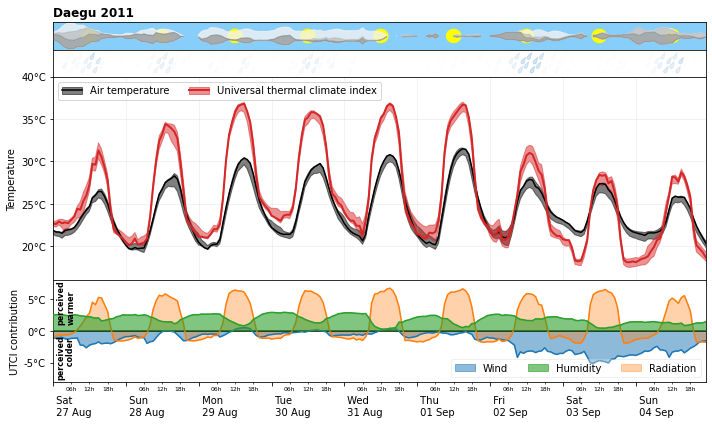

In [280]:
def clouds_plotter(axis,dates,highcloud,midcloud,lowcloud):
    """ Adds the different types of clouds to a given axis."""
    # add sun (and moon?)
    idate = datetime.datetime(dates[0].year,dates[0].month,dates[0].day,12)
    while idate < dates[-1]:
        #sun = Circle((dates[t], 0.5), 0.2, color='yellow', zorder=0)
        sun = Ellipse((idate, 0.5), 0.4/2., 0.5, angle=0.0, color='yellow', zorder=0)
        axis.add_artist(sun)
        idate = idate + datetime.timedelta(1)
        
    highcloud = np.median(highcloud,axis=(1,2))
    midcloud = np.median(midcloud,axis=(1,2))
    lowcloud = np.median(lowcloud,axis=(1,2))
        
    totalcloud=(highcloud+midcloud+lowcloud)/3.
    totalcloudhalf=totalcloud/2.
    lowerbound=-totalcloudhalf+0.5
    upperbound=totalcloudhalf+0.5

    # don't plot clouds where totalcloud <= e.g. 0.05
    threshold=0.03

    # highcloud light grey, lowcloud dark grey
    axis.fill_between(dates, y1=lowerbound, y2=upperbound, color='0.95',zorder=1, alpha=0.8, edgecolor='none',where=totalcloud>=threshold)
    axis.fill_between(dates, y1=lowerbound, y2=upperbound-highcloud/3., color='0.7',zorder=2, alpha=0.6, edgecolor='none',where=totalcloud>=threshold)
    axis.fill_between(dates, y1=lowerbound, y2=lowerbound+lowcloud/3.,  color='0.4',zorder=3, alpha=0.3, edgecolor='none',where=totalcloud>=threshold)
    axis.set_facecolor('lightskyblue')

## plot
fig = plt.figure(figsize=(10,6))
all_ax = gridspec.GridSpec(4, 1, height_ratios=[0.8,.8,6,3],hspace=0)
cloud_ax = plt.subplot(all_ax[0])
rain_ax = plt.subplot(all_ax[1])
ax = plt.subplot(all_ax[2])
cont_ax = plt.subplot(all_ax[3])

dt = datetime.timedelta(hours=0.9) #used to shift symbols left/right
dropletpath = droplet(rot=-30)

# heavy rain
nlen = 2*720  # less than 743 but dividable by 2,3,4,5,6
rgba_colors = np.zeros(nlen)     
rgba = [(0.12,0.46,0.7,np.sqrt(max(precip[i],0))) for i in range(nlen)]

timesc = time[1:nlen+1]

rain_ax.scatter(timesc[::4],[.2,]*(nlen//4),80,rgba[::4],marker=dropletpath)
rain_ax.scatter(timesc[1::4],[.6,]*(nlen//4),80,rgba[1::4],marker=dropletpath)
rain_ax.scatter(timesc[2::4],[.4,]*(nlen//4),80,rgba[2::4],marker=dropletpath)
rain_ax.scatter(timesc[3::4],[.8,]*(nlen//4),80,rgba[3::4],marker=dropletpath)

# CLOUDS
clouds_plotter(cloud_ax,time,hcc,mcc,lcc)

# LABEL FORMATTING
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'+u'\N{DEGREE SIGN}'+'C'))
cont_ax.yaxis.set_major_formatter(FormatStrFormatter('%d'+u'\N{DEGREE SIGN}'+'C'))
cont_ax.xaxis.set_minor_locator(HourLocator(np.arange(6, 25, 6)))    # minor
# cont_ax.xaxis.set_major_locator(HourLocator([0]))    # minor
cont_ax.xaxis.set_minor_formatter(DateFormatter("%Hh"))
cont_ax.get_xaxis().set_tick_params(which='minor', direction='out',pad=2,labelsize=6)
cont_ax.xaxis.set_major_formatter(DateFormatter(" %a\n %d %b"))
plt.setp(cont_ax.get_xticklabels(), ha="left")
cont_ax.get_xaxis().set_tick_params(which='major', direction='out',pad=10,labelsize=10)
ax.grid(alpha=0.2)
ax.set_xticklabels([])
rain_ax.set_xticks([])
cloud_ax.set_xticks([])
cloud_ax.set_yticks([])
cont_ax.set_yticks([-10,-5,0,5,10])
rain_ax.set_yticks([])

# LIMITS
ax.set_xlim(tstart,tend)
cont_ax.set_xlim(tstart,tend)
rain_ax.set_xlim(tstart,tend)
cloud_ax.set_xlim(tstart,tend)
ax.set_ylim(16,40)
cont_ax.set_ylim(-8,8)
rain_ax.set_ylim(-0.1,1.1)
cloud_ax.set_ylim(0, 1)

# TITLES
tstart1h = tstart+datetime.timedelta(hours=1)
cloud_ax.set_title("Daegu 2011", loc="left",fontweight="bold")
ax.set_ylabel("Temperature")
cont_ax.set_ylabel("UTCI contribution")
cont_ax.text(tstart1h,1.3,"perceived\nwarmer",rotation=90,fontsize=8,fontweight="bold",zorder=10)
cont_ax.text(tstart1h,-0.5,"perceived\n     colder",rotation=90,fontsize=8,va="top",fontweight="bold",zorder=10)

# DATA PLOTTING
l1, = ax.plot(time,T[:,2,2],"k")
l2, = ax.plot(time[1:],UTCI[:,2,2],"C3",lw=2)
f1 = ax.fill_between(time,np.percentile(T,10,axis=(1,2)),np.percentile(T,90,axis=(1,2)),color="k",alpha=0.5)
f2 = ax.fill_between(time[1:],np.percentile(UTCI,10,axis=(1,2)),np.percentile(UTCI,90,axis=(1,2)),color="C3",alpha=0.5)

# CONTRIBUTIONS TO UTCI
cont_ax.plot(time,np.zeros_like(T[:,2,2]),"k")
cont_ax.plot(time[1:],UTCIwind[:,2,2]-T[1:,2,2],color="C0")
cont_ax.plot(time[1:],UTCIrh[:,2,2]-T[1:,2,2],color="C2",zorder=5)
cont_ax.plot(time[1:],UTCImrt[:,2,2]-T[1:,2,2],color="C1")

cont_ax.fill_between(time[1:],UTCIwind[:,2,2]-T[1:,2,2],color="C0",alpha=0.5,label="Wind")
cont_ax.fill_between(time[1:],UTCIrh[:,2,2]-T[1:,2,2],color="C2",alpha=0.6,label="Humidity",zorder=5)
cont_ax.fill_between(time[1:],UTCImrt[:,2,2]-T[1:,2,2],color="C1",alpha=0.35,label="Radiation")

labels = ["Air temperature","Universal thermal climate index"]
ax.legend([(l1,f1),(l2,f2)],labels,loc=2,ncol=2)
cont_ax.legend(loc=4,ncol=3,framealpha=0.3)

plt.tight_layout()
plt.show()

__Fig. X__: Meteogram for Daegu, describing the weather during the World Championships in Athletics in 2011. Cloudiness is presented at the top, with hourly precipitation underneath. The difference between the temperature and perceived temperature (universal thermal climate index, UTCI) is decomposed into contributions from wind, humidity and radiation in the bottom panel.